In [1]:
import os 
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas() 
from datetime import datetime, timedelta
from collections import Counter
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import seaborn as sns
from scipy.stats import norm
warnings.filterwarnings("ignore")

In [2]:
os.chdir('./ddps')
# original dataset
data=pd.read_pickle("data_transformed_cleaned.pkl")

**Session duration**

In [5]:
# duration
def process_user_data(df):
    processed = []
    df=df.sort_values(by=['timestamp_converted'])
    # iterate over rows
    for index, row in df.iterrows():
        if processed:
            last_activity = processed[-1] # create a reference to the dictionary last activity to update it 
            #  time difference 
            time_diff = (row['timestamp_converted'] - last_activity['end_time']).total_seconds() / 60
            # Check if the current activity is the same type and within 10 minutes 
            if last_activity['activity_type'] == row['activity_type'] and time_diff <= 10:
                # Extend the current activity duration by updating the end_time to the latest one
                last_activity['end_time'] = row['timestamp_converted']
            else:
                # calculate duration for the last activity
                last_activity['duration'] = (last_activity['end_time'] - last_activity['start_time']).total_seconds() / 60
                
                # a new activity type or more than 10 mins have passed since the last activity
                new_activity = row.to_dict()
                new_activity['start_time'] = row['timestamp_converted']
                new_activity['end_time'] = row['timestamp_converted']
                processed.append(new_activity)
        else:
            # empty, add the first row with initial start and end times
            new_activity = row.to_dict()
            new_activity['start_time'] = row['timestamp_converted']
            new_activity['end_time'] = row['timestamp_converted']
            processed.append(new_activity)

    # duration for the last activity in the list after the loop
    if processed:
        last_activity = processed[-1]
        last_activity['duration'] = (last_activity['end_time'] - last_activity['start_time']).total_seconds() / 60

    return pd.DataFrame(processed)




In [6]:
grouped = data.sort_values(by=['timestamp_converted']).groupby(['user_id'])
data_duration=pd.concat([process_user_data(group) for _, group in grouped])
data_duration=data_duration[data_duration.duration>0].reset_index(drop=True)

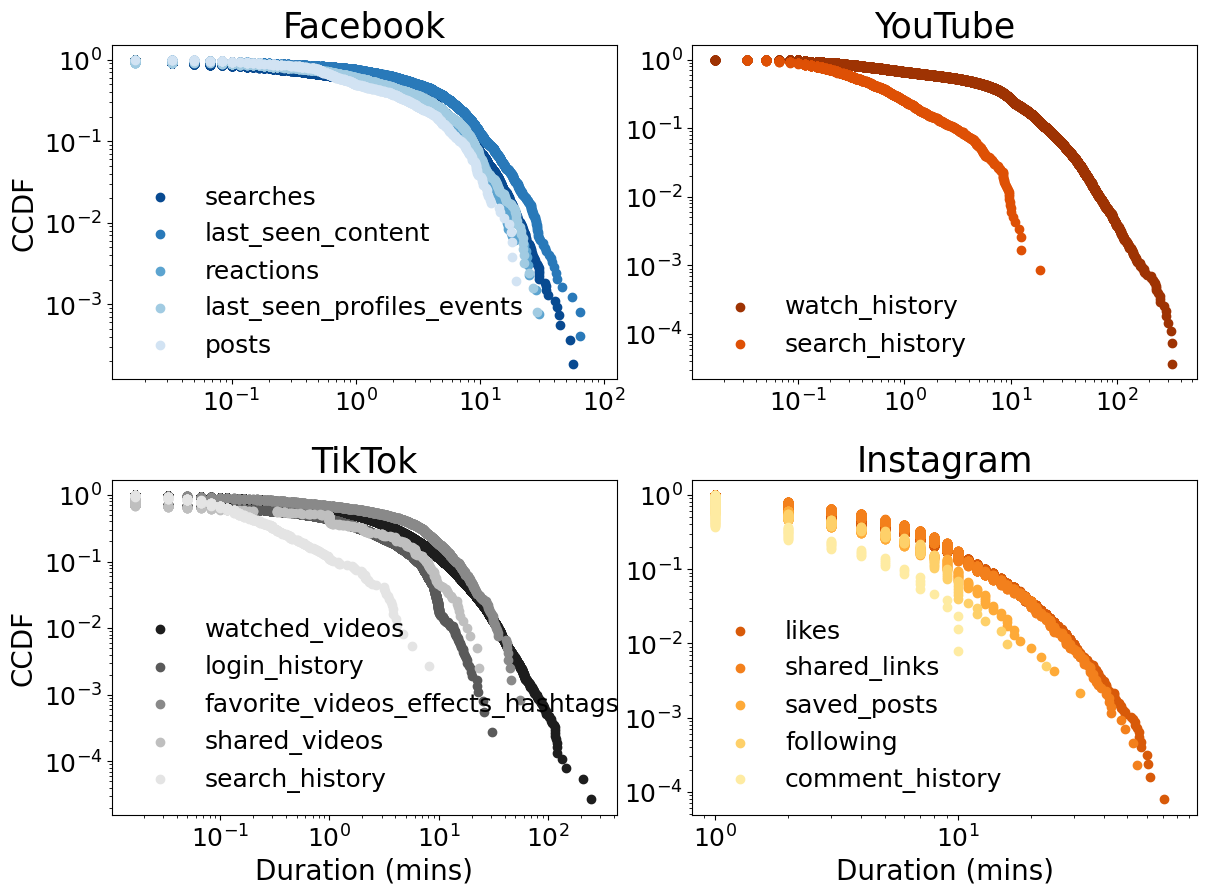

In [7]:
### plot duration sessions 
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  
fig.subplots_adjust(hspace=0.3, wspace=0.15)  
label_dict = {'instagram': "Instagram", 'facebook': "Facebook", 'tiktok': "TikTok", "youtube":"YouTube"}
platform = [ 'facebook',  'youtube',  'tiktok', 'instagram', ]
colormap = {'instagram': "YlOrBr", 'facebook': "Blues", 'tiktok': "Greys", "youtube":"Oranges"} 
ax_flat = axs.flatten() 

for ax, n in zip(ax_flat, platform):  
    df_new1 = data_duration[data_duration.platform == n]
    top_5=df_new1.groupby("activity_type").size().reset_index().sort_values([0], ascending=False).activity_type.to_list()[:5]
    cmap = plt.get_cmap(colormap[n])
    colors = cmap(np.linspace(0.1, 0.9, 10))[::-2]
    if n=="instagram":
        cmap = plt.get_cmap(colormap[n])
        colors = cmap(np.linspace(0.2, 0.7, 5))[::-1]
        #ax.set_ylim(0,1500)
    a=0# Avoid very light colors
    for p in top_5:
        df_new2 = df_new1[df_new1.activity_type == p]
        durations=df_new2.duration
        sorted_durations = np.sort(durations)
        ccdf = 1. - np.arange(1, len(durations) + 1) / len(durations)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.scatter(sorted_durations, ccdf,  marker='o', color=colors[a], label="_".join(p.split("_")[:4]),)
        a+=1
    if n in ["facebook", "tiktok"]:
        ax.set_ylabel('CCDF', fontsize=20)
    if n in ["instagram", "tiktok"]:   
        ax.set_xlabel('Duration (mins)', fontsize=20)
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=18)
    leg=ax.legend(fontsize=18, loc="best")
    for line in leg.get_lines():
        line.set_linewidth(4)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
    colors = cmap(np.linspace(0.1, 0.9, 10))[::-2]
    if n=="tiktok":
        cmap = plt.get_cmap(colormap[n])
        colors = cmap(np.linspace(0.1, 0.8, 5))[::-1]
        #ax.set_ylim(0,700)
        
    ax.set_title(label_dict[n],fontsize=25)
    ax.set_ylim(0,)
   


plt.show()

**platform switch**

In [9]:
def platform_switch(df):

    # Detect platform switch by checking if the current platform is different from the previous one (for the same 'case_id')
    df['platform_switch'] = df['platform'] != df.groupby('user_id')['platform'].shift()
    new_data = []

    for idx, row in df.iterrows():
        # Append the original row to the new_data list
        new_data.append(row)
        try:
            # If a platform switch is detected, insert a new row just before the switch
            if idx>0 and row['platform_switch']:
                # Copy the current row and modify it
                new_row = row.copy()
                # Set the platform to the previous one (before the switch)
                new_row['platform'] = df.loc[idx, 'platform']
                new_row['activity_type'] = f"platform_switch"
                
                # Set the timestamp to one second before the current row's timestamp
                new_row['start_time'] = row['start_time'] - pd.Timedelta(seconds=1)
                new_row['end_time'] = row['start_time']
                new_row['duration'] = np.nan
                
                # Append the new row to the new_data list
                new_data.append(new_row)
        except:
            pass

    # Convert the new_data list back into a DataFrame
    df_expanded = pd.DataFrame(new_data).sort_values(by=['start_time', 'user_id']).reset_index(drop=True)

    # Drop the 'platform_switch' column, as it's no longer needed
    df_expanded = df_expanded.drop(columns=['platform_switch'])
    return df_expanded

In [10]:
grouped = data_duration.groupby(['user_id'])
data_switch=pd.concat([platform_switch(group.reset_index(drop=True)) for _, group in grouped]).reset_index(drop=True)

In [11]:
### some preprocessing 
data_switch["platform_switch"]=data_switch.activity_type.apply(lambda x: 1 if x=="platform_switch" else 0)
index=data_switch[data_switch.activity_type=="platform_switch"].index.values-1
data_switch.loc[index, "platform_switch"]=1
data_switch=data_switch[data_switch.activity_type!="platform_switch"]

In [12]:

# for 2+ platform users 
df_new1=data.groupby(["platform", "user_id"]).size().reset_index()
df_plat=df_new1.groupby("user_id").count().reset_index()
df_plat.groupby("platform").count().reset_index()
users=df_plat[df_plat.platform>1].user_id.to_list()
data_switch=data_switch[data_switch.user_id.isin(users)]

In [13]:
### event history analysis 

# Selecting covariates
covariates = ['platform']  # Replace with your actual covariate columns

# Preparing the final dataset for modeling
survival_data = data_switch[['user_id', 'duration', 'platform_switch'] + covariates]

print(survival_data.head())


            user_id   duration  platform_switch platform
80  284269849006135  43.966667                0  youtube
81  284269849006135   8.550000                0  youtube
82  284269849006135   6.783333                0  youtube
83  284269849006135   0.833333                0  youtube
84  284269849006135   0.133333                0  youtube


In [14]:
data_encoded = pd.get_dummies(survival_data, columns=covariates)

In [17]:
data_encoded.head()

,user_id,duration,platform_switch,platform_facebook,platform_instagram,platform_tiktok,platform_youtube
80,284269849006135,43.966667,0,0,0,0,1
81,284269849006135,8.550000,0,0,0,0,1
82,284269849006135,6.783333,0,0,0,0,1
83,284269849006135,0.833333,0,0,0,0,1
84,284269849006135,0.133333,0,0,0,0,1


In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'data' is your DataFrame and it includes only the covariates and the dependent variable
features = data_encoded[['platform_facebook', 'platform_instagram', 'platform_tiktok', 'platform_youtube']]  # Adjust column names if necessary
vif_data = pd.DataFrame()
vif_data['feature'] = features.columns

# Calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

print(vif_data)


              feature       VIF
0   platform_facebook  0.028924
1  platform_instagram  0.002005
2     platform_tiktok  0.009078
3    platform_youtube  0.005570


**univariate**

In [19]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [20]:
T = survival_data["duration"]
E = survival_data["platform_switch"]

kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 50650 total observations, 42917 right-censored observations>

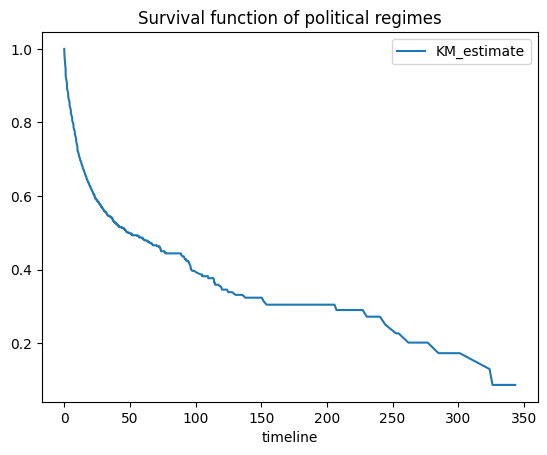

In [21]:
from matplotlib import pyplot as plt


kmf.survival_function_.plot()
plt.title('Survival function of political regimes');

<AxesSubplot:xlabel='timeline'>

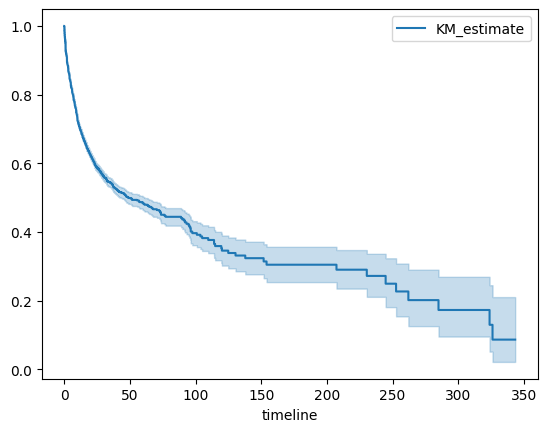

In [22]:
kmf.plot_survival_function()

In [23]:
kmf.median_survival_time_ # the median time did not switch platform 

48.63333333333333

In [24]:
from lifelines.utils import median_survival_times
median_ci = median_survival_times(kmf.confidence_interval_)

Text(0.5, 0, 'Mins')

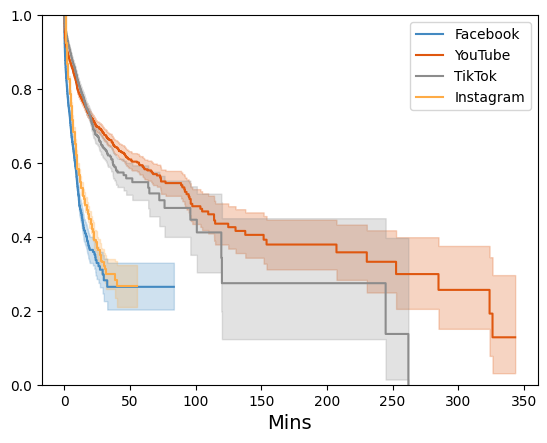

In [25]:
ax = plt.subplot(111)
color_dict = {'instagram': "#feab46", 'facebook': "#4389c1", 'tiktok': "#8c8c8c", "youtube":"#df570f"}

dem = (survival_data["platform"] == "tiktok")
dem1 = (survival_data["platform"] == "facebook")
dem2 = (survival_data["platform"] == "youtube")
dem3 = (survival_data["platform"] == "instagram")



kmf.fit(T[dem1], event_observed=E[dem1], label="Facebook")
kmf.plot_survival_function(ax=ax, color=color_dict["facebook"])

kmf.fit(T[dem2], event_observed=E[dem2], label="YouTube")
kmf.plot_survival_function(ax=ax, color=color_dict["youtube"])
kmf.fit(T[dem], event_observed=E[dem], label="TikTok")
kmf.plot_survival_function(ax=ax, color=color_dict["tiktok"])

kmf.fit(T[dem3], event_observed=E[dem3], label="Instagram")
kmf.plot_survival_function(ax=ax, color=color_dict["instagram"])

ax.set_ylim([0, 1])

ax.set_xlabel('Mins', size = 14)
#plt.title("Duration on different platform until platform switches");

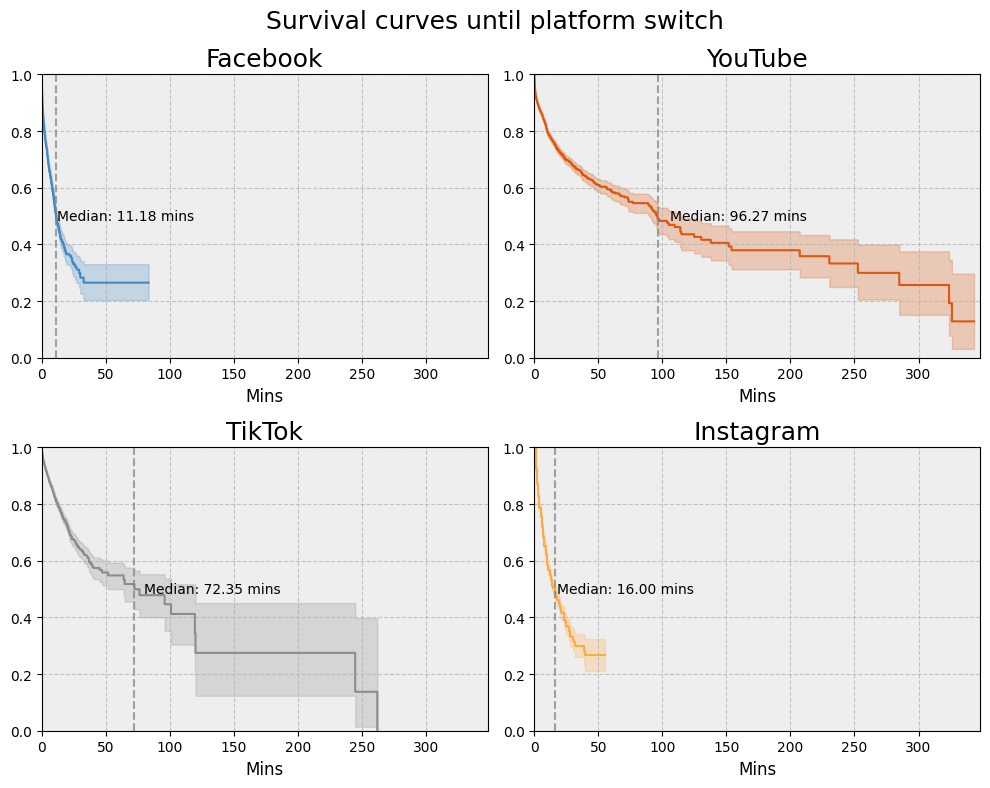

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
color_dict = {'instagram': "#feab46", 'facebook': "#4389c1", 'tiktok': "#8c8c8c", "youtube":"#df570f"}
platforms = ['facebook', 'youtube', 'tiktok', 'instagram']
labels = {'instagram': "Instagram", 'facebook': "Facebook", 'tiktok': "TikTok", "youtube":"YouTube"}

for ax, platform in zip(axs.flatten(), platforms):
    mask = (survival_data["platform"] == platform)
    kmf.fit(T[mask], event_observed=E[mask], label=labels[platform])
    kmf.plot_survival_function(ax=ax, color=color_dict[platform])
    ax.get_legend().remove() 
    
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 348])
    ax.set_xlabel('Mins', size=12)
    ax.set_title(f"{labels[platform]}", size=18)
    ax.set_facecolor('#eeeeee')
    
    # Add median survival time to each plot
    median_time = kmf.median_survival_time_
    ax.axvline(x=median_time, color='gray', linestyle='--', alpha=0.7)
    ax.text(median_time*1.1, 0.5, f'Median: {median_time:.2f} mins', 
            fontsize=10, verticalalignment='center')
    ax.grid(True, linestyle='--', alpha=0.7)

fig.suptitle('Survival curves until platform switch', size=18)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.savefig('../survival1.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi


cph = CoxPHFitter()
#data_reduced = data_encoded.drop('platform_instagram', axis=1)

# Fit the Cox model again
cph.fit(data_encoded[['duration', 'platform_switch', 'platform_facebook', 'platform_tiktok', 'platform_instagram']], duration_col='duration', event_col='platform_switch', show_progress=True)

# Print the model's summary to see if multicollinearity issues are resolved


Iteration 1: norm_delta = 5.42e-01, step_size = 0.9500, log_lik = -75944.76849, newton_decrement = 9.22e+02, seconds_since_start = 0.5
Iteration 2: norm_delta = 8.02e-02, step_size = 0.9500, log_lik = -75158.13228, newton_decrement = 3.29e+01, seconds_since_start = 0.9
Iteration 3: norm_delta = 7.50e-03, step_size = 0.9500, log_lik = -75124.45694, newton_decrement = 3.22e-01, seconds_since_start = 1.2
Iteration 4: norm_delta = 4.66e-05, step_size = 1.0000, log_lik = -75124.13333, newton_decrement = 1.26e-05, seconds_since_start = 1.5
Iteration 5: norm_delta = 1.85e-09, step_size = 1.0000, log_lik = -75124.13331, newton_decrement = 1.96e-14, seconds_since_start = 2.2
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 50650 total observations, 42917 right-censored observations>

In [34]:
print(cph.summary)


                        coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                           
platform_facebook   1.063972   2.897857  0.034172        0.996995   
platform_tiktok    -0.129939   0.878149  0.033417       -0.195436   
platform_instagram  0.720784   2.056045  0.031007        0.660011   

                    coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                      
platform_facebook         1.130948             2.710127             3.098591   
platform_tiktok          -0.064443             0.822476             0.937589   
platform_instagram        0.781557             1.934814             2.184871   

                    cmp to          z              p    -log2(p)  
covariate                                                         
platform_facebook      0.0  31.135671  7.928326e-213  704.583668  
platform_tiktok        0.0  -3.888408   1.009038e-04